# Data Collection

0.06138181686401367


(array([  5.,   9.,  10.,  13.,  21.,  14.,  27.,  35.,  35.,  41.,  38.,
         49.,  66.,  62.,  69.,  92., 114., 155., 135., 142., 153., 141.,
        155., 175., 198., 183., 175., 194., 209., 188., 245., 258., 266.,
        279., 328., 339., 335., 361., 339., 360., 359., 379., 349., 360.,
        362., 382., 367., 429., 429., 571.]),
 array([2.01398283, 2.0717777 , 2.12957257, 2.18736744, 2.24516231,
        2.30295718, 2.36075205, 2.41854692, 2.47634179, 2.53413666,
        2.59193153, 2.6497264 , 2.70752127, 2.76531614, 2.82311101,
        2.88090588, 2.93870075, 2.99649562, 3.05429049, 3.11208536,
        3.16988023, 3.2276751 , 3.28546997, 3.34326484, 3.40105971,
        3.45885458, 3.51664945, 3.57444432, 3.63223919, 3.69003407,
        3.74782894, 3.80562381, 3.86341868, 3.92121355, 3.97900842,
        4.03680329, 4.09459816, 4.15239303, 4.2101879 , 4.26798277,
        4.32577764, 4.38357251, 4.44136738, 4.49916225, 4.55695712,
        4.61475199, 4.67254686, 4.73034173, 4.

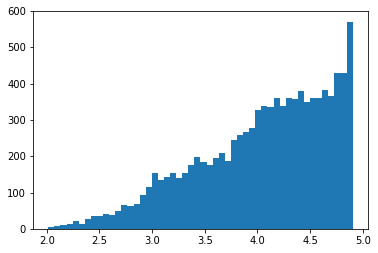

In [29]:
from math import*
import __main__
global PI
import os
import time
PI=float(acos(-1))

import random
import numpy as np
import multiprocessing as mp

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm

%matplotlib inline

rs_number = 123
random.seed(rs_number)

data_size = 10000;

random_selection = 0

if random_selection==0:
    ''' random selection'''
#     mu = [0,0]
#     cov = [[1, 0], [0, 1]]
#     datasets = np.random.multivariate_normal(mu, cov, data_size)
    x0 = np.random.uniform(0,1,data_size)
    x1 = np.random.uniform(0,1,data_size)
    x = [x0, x1]
    datasets = np.reshape(x,(data_size,2))
else:
    '''latin hypercube sampling'''

# print(np.shape(datasets)) 
# plt.plot(datasets[:,0],datasets[:,1],'o')

def ssh(X):
    c = 4
    g = c-X[0]/c + sin(c*X[0])-X[1]**3
#     g = 0.7*norm.pdf(X,3,1) + 0.3*norm.pdf(X,6,1)
#     g = 0.7*norm.ppf(X, loc=3, scale=1) + 0.3*norm.ppf(X, loc=10, scale=1)
#     g = lognorm.ppf([0.001, 0.5, 0.999], X)
    return g


# map async parallel 
# pool = mp.Pool(mp.cpu_count())
pool = mp.Pool(processes = 2)

start = time.time()
results_map = pool.map(ssh, datasets)
end = time.time() 
print(end - start) #0.0037827491760253906

# print(results_map)

# # rare event probability
# num = 0
# for i in range(data_size):
#     if results_map[i]<0:
#         num = num+1

# prob = num/data_size
# print(prob)

plt.hist(results_map,50)


In [30]:
datasets2 = np.reshape(datasets,(10000,2))
np.shape(datasets2)
# type(datasets)

(10000, 2)

# Data classification and preprocessing

In [31]:
results_map_sort = sorted(results_map) # note that sorted change the sort but didn't change the original one
# print(results_map_sort)
median_value = results_map_sort[data_size//2]
# median_value = 3.5
print(median_value)

results_map_new = np.zeros((data_size,1))
output_scikit = np.zeros(data_size)

for i in range(data_size):
    if results_map[i] > median_value:
        results_map_new[i,:] = 1
        output_scikit[i] = 1
    else:
        results_map_new[i,:] = 0
        output_scikit[i] = 0

y_data = output_scikit

4.157587087702216


# Training by classification 

In [32]:
# scikit-learn MLP training 
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression

# preprocessing data scale? X is [1,10]
trans_mean = np.mean(datasets)
trans_std = np.std(datasets)

data_scale = 2
if data_scale==0:
    X_data = preprocessing.scale(datasets)
elif data_scale ==1:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_data = min_max_scaler.fit_transform(datasets)
elif data_scale ==2:
    scaler = preprocessing.StandardScaler().fit(datasets) # can be used for the following iteration 
    X_data = scaler.transform(datasets)  

# sgd optimizer 
# mlp = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4, hidden_layer_sizes=(128, 128),
#                     random_state=1, max_iter=10000,verbose=True)

mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-4, hidden_layer_sizes=(50,50,50,50),
                    random_state=1, max_iter=1000,verbose=True,learning_rate = 'adaptive')

# lbfgs - very slow 
# mlp = MLPClassifier(solver='lbfgs', activation='relu',alpha=1e-4,hidden_layer_sizes=(100,100),
#                     random_state=1,max_iter=50,verbose=10,learning_rate_init=.1)
# adam 
# mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(100,100),
#                     random_state=1,max_iter=50,verbose=10,learning_rate_init=.1)

# testing and training data 
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,random_state=rs_number)

# training 
# kernel = 1.0 * RBF(1.0)
# mlp = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train, y_train)
# print(mlp,score(X_train, y_train))
mlp.fit(X_train, y_train) 

# mlp = LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',verbose=1, n_jobs = 4).fit(X_train, y_train)

#testing
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (train) for %0.1f%% " % (accuracy * 100))

# # cross-validation 
# score_cv = cross_val_score(mlp, X_data, y_data,cv=5)  
# print(score_cv)

## tuning hyperparameters 

# 10000 data, [0.84457771 0.854      0.8385     0.845      0.85992996], default
# 10000 data, [0.82908546 0.835      0.8235     0.8185     0.82391196], feature[1,10] normalization 效果一般
# 10000 data, [0.86206897 0.8605     0.8375     0.854      0.8154077 ], feature[0,1] normalization 效果一般
# 10000 data, [0.84457771 0.854      0.8385     0.845      0.85992996], StandardScaler()

Iteration 1, loss = 0.52954826
Iteration 2, loss = 0.20049730
Iteration 3, loss = 0.07476135
Iteration 4, loss = 0.04720042
Iteration 5, loss = 0.03781071
Iteration 6, loss = 0.03229842
Iteration 7, loss = 0.02702488
Iteration 8, loss = 0.02382095
Iteration 9, loss = 0.02196087
Iteration 10, loss = 0.02178616
Iteration 11, loss = 0.02443034
Iteration 12, loss = 0.01926126
Iteration 13, loss = 0.01649766
Iteration 14, loss = 0.01878661
Iteration 15, loss = 0.01540790
Iteration 16, loss = 0.01867933
Iteration 17, loss = 0.01674328
Iteration 18, loss = 0.02247639
Iteration 19, loss = 0.01390420
Iteration 20, loss = 0.01377879
Iteration 21, loss = 0.01682865
Iteration 22, loss = 0.01384273
Iteration 23, loss = 0.01250218
Iteration 24, loss = 0.01647294
Iteration 25, loss = 0.01303449
Iteration 26, loss = 0.01222780
Iteration 27, loss = 0.01198007
Iteration 28, loss = 0.01684883
Iteration 29, loss = 0.01845395
Iteration 30, loss = 0.01361800
Iteration 31, loss = 0.01633302
Iteration 32, los

# ML rank VS FEM rank

[5884, 9482, 6588, 670, 7514, 1735, 5614, 1737, 7006, 4553, 3023, 8760, 8803, 3233, 4475, 4641, 5304, 7488, 2906, 1833]
[5884, 5614, 1737, 670, 9482, 3023, 8760, 7514, 6588, 5304, 3233, 1735, 1833, 4553, 2906, 9182, 7006, 8803, 7488, 9507]


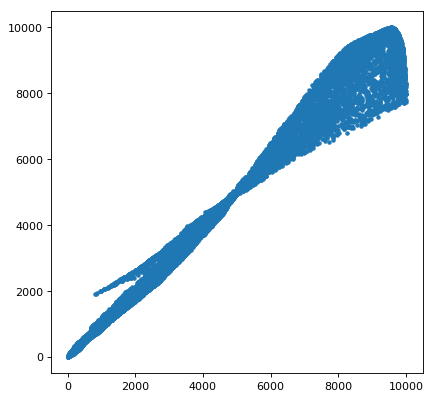

In [33]:
sort_index_FEM = np.argsort(results_map)
probs = mlp.predict_proba(X_data)
# print(probs)
sort_index_mlp = np.argsort(probs[:][:,1])

sort_FEM = sort_index_FEM.tolist()
sort_mlp = sort_index_mlp.tolist()

print(sort_FEM[0:20])
print(sort_mlp[0:20])

rank_mlp = []
for j in range(data_size):
    rank_fem = sort_FEM[j]
    rank_mlp0 = sort_mlp.index(rank_fem)
#     print(rank_mlp0)
    rank_mlp.append(rank_mlp0)


plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(data_size),rank_mlp,'.')
